In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')
checked = data[data['checked'] == 1]
checked


,adres_aantal_brp_adres,adres_aantal_verschillende_wijken,adres_aantal_verzendadres,adres_aantal_woonadres_handmatig,adres_dagen_op_adres,adres_recentst_onderdeel_rdam,adres_recentste_buurt_groot_ijsselmonde,adres_recentste_buurt_nieuwe_westen,adres_recentste_buurt_other,adres_recentste_buurt_oude_noorden,...,typering_hist_aantal,typering_hist_inburgeringsbehoeftig,typering_hist_ind,typering_hist_sector_zorg,typering_ind,typering_indicatie_geheime_gegevens,typering_other,typering_transport__logistiek___tuinbouw,typering_zorg__schoonmaak___welzijn,checked
1,4,2,1,0,5268,1,0,0,0,0,...,2,0,1,0,1,0,1,0,0,1
2,4,2,0,1,1820,1,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
5,2,2,0,0,14053,1,0,0,1,0,...,2,0,1,0,1,0,0,0,0,1
10,4,3,1,1,3706,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,1
13,3,3,1,2,6592,1,0,0,0,0,...,2,0,1,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12609,2,2,0,1,12511,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
12618,1,1,0,0,18494,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1
12629,3,3,1,1,3737,1,0,0,1,0,...,2,0,1,0,1,0,1,0,0,1
12634,5,3,1,0,188,1,0,0,0,0,...,1,0,1,0,1,0,0,0,0,1


In [3]:
# Let's specify the features and the target

valid_prefixes = [
    "afspraak_",
    "contacten_soort_",     # counts of call/email/etc, safe
    "instrument_",
    "deelname_",
    "pla_",
    "typering_",
    "ontheffing_"
]


good_features = [
    col for col in data.columns
    if any(col.startswith(p) for p in valid_prefixes)
]

X = data[good_features]
y = data['checked']

X = X.astype(np.float32)

print("Selected unbiased features:", len(good_features))
X.head()

# Let's split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Selected unbiased features: 132


In [4]:
# Select data based on variance (not the final version yet, for now just for testing)
selector = VarianceThreshold()

In [5]:
# Define a gradient boosting classifier
# classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
good_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),
    ("gb", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3
    ))
])

In [6]:
# Create a pipeline object with our selector and classifier
# NOTE: You can create custom pipeline objects but they must be registered to onnx or it will not recognise them
# Because of this we recommend using the onnx known objects as defined in the documentation
# pipeline = Pipeline(steps=[('feature selection', selector), ('classification', classifier)])

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      2856
           1       0.74      0.24      0.36       306

    accuracy                           0.92      3162
   macro avg       0.83      0.62      0.66      3162
weighted avg       0.91      0.92      0.90      3162



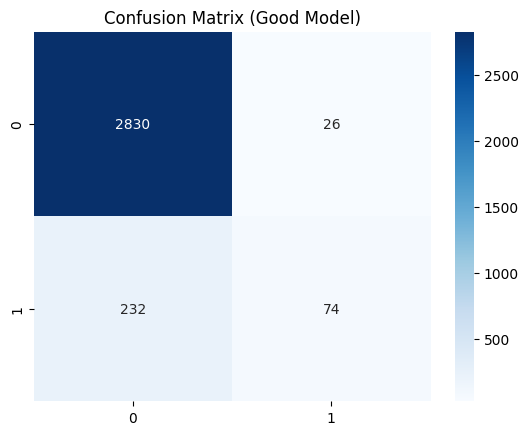

In [7]:
# Let's train a simple model
# pipeline.fit(X_train, y_train)
good_model.fit(X_train, y_train)


# Let's evaluate the model
# y_pred = pipeline.predict(X_test)
# original_accuracy = accuracy_score(y_test, y_pred)
# print('Accuracy of the original model: ', original_accuracy)

y_pred = good_model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Good Model)")
plt.show()


In [8]:
# Let's convert the model to ONNX
onnx_model = convert_sklearn(
    good_model, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.9184060721062619


In [9]:
# Let's save the model
onnx.save(onnx_model, "model/gboost_good_g2.onnx")

# Let's load the model
new_session = rt.InferenceSession("model/gboost.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9184060721062619


In [10]:
partitions = [
    # Gender-based partitions
    {"name": "men", "condition": lambda df: df['persoon_geslacht_vrouw'] == 0},
    {"name": "women", "condition": lambda df: df['persoon_geslacht_vrouw'] == 1},
    # Age-based partitions
    {"name": "young_adults", "condition": lambda df: df['persoon_leeftijd_bij_onderzoek'] < 30},
    {"name": "middle_aged", "condition": lambda df: (df['persoon_leeftijd_bij_onderzoek'] >= 30) & (df['persoon_leeftijd_bij_onderzoek'] < 60)},
    {"name": "seniors", "condition": lambda df: df['persoon_leeftijd_bij_onderzoek'] >= 60},
    # Family status
    {"name": "single_parents", "condition": lambda df: (df['relatie_kind_heeft_kinderen'] == 1) & (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0)},
    {"name": "married_with_children", "condition": lambda df: (df['relatie_kind_heeft_kinderen'] == 1) & (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 1)},
    {"name": "no_children_no_partner", "condition": lambda df: (df['relatie_kind_heeft_kinderen'] == 0) & (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0)},
    # Marital status
    {"name": "currently_married", "condition": lambda df: df['relatie_partner_huidige_partner___partner__gehuwd_'] == 1},
    {"name": "currently_unmarried_with_partner", "condition": lambda df: df['relatie_partner_aantal_partner___partner__ongehuwd_'] > 0},
    {"name": "currently_single", "condition": lambda df: (
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0) & 
        (df['relatie_partner_aantal_partner___partner__ongehuwd_'] == 0)
    )},
    {"name": "multiple_unmarried_partners", "condition": lambda df: df['relatie_partner_aantal_partner___partner__ongehuwd_'] > 1},
    {"name": "likely_divorced", "condition": lambda df: (
        (df['relatie_partner_aantal_partner___partner__gehuwd_'] > 0) &  # Had married partner historically
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0)  # Not currently married
    )},
    {"name": "likely_divorced_with_children", "condition": lambda df: (
        (df['relatie_partner_aantal_partner___partner__gehuwd_'] > 0) &
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0) &
        (df['relatie_kind_heeft_kinderen'] == 1)
    )},
    {"name": "likely_divorced_no_children", "condition": lambda df: (
        (df['relatie_partner_aantal_partner___partner__gehuwd_'] > 0) &
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0) &
        (df['relatie_kind_heeft_kinderen'] == 0)
    )},
    {"name": "divorced_women", "condition": lambda df: (
        (df['relatie_partner_aantal_partner___partner__gehuwd_'] > 0) &
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0) &
        (df['persoon_geslacht_vrouw'] == 1)
    )},
    {"name": "divorced_women_with_children", "condition": lambda df: (
        (df['relatie_partner_aantal_partner___partner__gehuwd_'] > 0) &
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0) &
        (df['persoon_geslacht_vrouw'] == 1) &
        (df['relatie_kind_heeft_kinderen'] == 1)
    )},
    # Currently cohabiting but not married
    {"name": "cohabiting_unmarried", "condition": lambda df: (
        (df['relatie_partner_aantal_partner___partner__ongehuwd_'] > 0) &
        (df['relatie_partner_huidige_partner___partner__gehuwd_'] == 0) &
        (df['relatie_overig_kostendeler'] == 1)  # Cost-sharer = living together
    )},
    # Dutch understanding
    {"name": "understands_dutch", "condition": lambda df: df['persoonlijke_eigenschappen_nl_begrijpen3'] == 1},
    {"name": "does_not_understand_dutch", "condition": lambda df: df['persoonlijke_eigenschappen_nl_begrijpen3'] == 0},
    # Short time at address + language issues (recent immigrants)
    {"name": "likely_recent_arrival_non_Dutch", "condition": lambda df: (
        (df['adres_dagen_op_adres'] < 365) & 
        (df['adres_recentste_plaats_rotterdam'] == 1) &
        (df['persoonlijke_eigenschappen_nl_begrijpen3'] == 0)
    )},
    {"name": "likely_recent_arrival_Dutch", "condition": lambda df: (
        (df['adres_dagen_op_adres'] < 365) & 
        (df['adres_recentste_plaats_rotterdam'] == 1) &
        (df['persoonlijke_eigenschappen_nl_begrijpen3'] == 1)
    )},
    {"name": "less_established_residents_non_Dutch", "condition": lambda df: (
        (df['adres_dagen_op_adres'] <= 1825) &
        (df['adres_recentste_plaats_rotterdam'] == 1) &
        (df['persoonlijke_eigenschappen_nl_begrijpen3'] == 0)
    )},
    {"name": "less_established_residents_Dutch", "condition": lambda df: (
        (df['adres_dagen_op_adres'] <= 1825) &
        (df['adres_recentste_plaats_rotterdam'] == 1) &
        (df['persoonlijke_eigenschappen_nl_begrijpen3'] == 1)
    )},
    {"name": "established_residents_non_Dutch", "condition": lambda df: (
        (df['adres_dagen_op_adres'] > 1825) &  # 5+ years
        (df['adres_recentste_plaats_rotterdam'] == 1) &
        (df['persoonlijke_eigenschappen_nl_begrijpen3'] == 0)
    )},
    {"name": "established_residents_Dutch", "condition": lambda df: (
        (df['adres_dagen_op_adres'] > 1825) &  # 5+ years
        (df['adres_recentste_plaats_rotterdam'] == 1) &
        (df['persoonlijke_eigenschappen_nl_begrijpen3'] == 1)
    )},
    # Most recent borough
    {"name": "charlois", "condition": lambda df: df['adres_recentste_wijk_charlois'] == 1},
    {"name": "delfshaven", "condition": lambda df: df['adres_recentste_wijk_delfshaven'] == 1},
    {"name": "feijenoord", "condition": lambda df: df['adres_recentste_wijk_feijenoord'] == 1},
    {"name": "ijsselmonde", "condition": lambda df: df['adres_recentste_wijk_ijsselmonde'] == 1},
    {"name": "kralingen_c", "condition": lambda df: df['adres_recentste_wijk_kralingen_c'] == 1},
    {"name": "noord", "condition": lambda df: df['adres_recentste_wijk_noord'] == 1},
    {"name": "prins_alexa", "condition": lambda df: df['adres_recentste_wijk_prins_alexa'] == 1},
    {"name": "stadscentru", "condition": lambda df: df['adres_recentste_wijk_stadscentru'] == 1},
    # Obstacles
    {"name": "psychological_obstacles", "condition": lambda df: df['belemmering_psychische_problemen'] == 1},
    {"name": "no_psychological_obstacles", "condition": lambda df: df['belemmering_psychische_problemen'] == 0},
    {"name": "living_situation_obstacles", "condition": lambda df: df['belemmering_woonsituatie'] == 1},
    {"name": "no_living_situation_obstacles", "condition": lambda df: df['belemmering_woonsituatie'] == 0},
    {"name": "financial_obstacles", "condition": lambda df: df['belemmering_financiele_problemen'] == 1},
    {"name": "no_financial_obstacles", "condition": lambda df: df['belemmering_financiele_problemen'] == 0},
    # Multiple obstacles
    {"name": "psychological_financial_obstacles", "condition": lambda df: (
        (df['belemmering_psychische_problemen'] == 1) & 
        (df['belemmering_financiele_problemen'] == 1)
    )},
    {"name": "psychological_financial_living_obstacles", "condition": lambda df: (
        (df['belemmering_psychische_problemen'] == 1) & 
        (df['belemmering_financiele_problemen'] == 1) &
        (df['belemmering_woonsituatie'] == 1)
    )},
    {"name": "no_obstacles", "condition": lambda df: (
        (df['belemmering_psychische_problemen'] == 0) & 
        (df['belemmering_financiele_problemen'] == 0) &
        (df['belemmering_woonsituatie'] == 0)
    )},
]

In [11]:
import os
import json
from collections import Counter

results = []
for partition in partitions:
    partition_name = partition["name"]
    condition = partition["condition"]

    # Filter the test set based on the partition condition
    X_test_partition = X_test[condition(X_test)]
    y_test_partition = y_test[condition(X_test)]

    if len(X_test_partition) == 0:
        print(f'No data for partition: {partition_name}')
        continue

    # Predict using the ONNX model
    y_pred_partition = new_session.run(None, {'X': X_test_partition.values.astype(np.float32)})
    pred_array = y_pred_partition[0]
    # If the model returns probabilities/scores, convert to label indices
    if getattr(pred_array, 'ndim', 1) == 2 and pred_array.shape[1] > 1:
        labels = np.argmax(pred_array, axis=1)
    else:
        labels = np.ravel(pred_array)

    # Calculate accuracy using the (possibly converted) labels
    accuracy_partition = accuracy_score(y_test_partition, labels)
    preds, counts = np.unique(labels, return_counts=True)
    pred_counts = {int(k): int(v) for k, v in zip(preds.tolist(), counts.tolist())}

    entry = {
        'partition': partition_name,
        'num_samples': int(len(X_test_partition)),
        'accuracy': float(accuracy_partition),
        'prediction_counts': pred_counts,
    }
    results.append(entry)

    print(f'Partition: {partition_name}')
    print(f'Number of data points: {len(X_test_partition)}')
    print(f'Accuracy: {accuracy_partition}')
    print(f'Prediction counts: {pred_counts}\n')

# Ensure results directory exists and write JSON file
os.makedirs('results', exist_ok=True)
with open(os.path.join('results', 'partition_results.json'), 'w') as f:
    json.dump(results, f, indent=2)
print('Wrote results to results/partition_results.json')

KeyError: 'persoon_geslacht_vrouw'